### EKE at 500m - correlations between ekman in the trough and the pstream slope area. 
### - the EKE vs T separate time series to add on the slope figure. 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'



import cosima_cookbook as cc

from cosima_cookbook import distributed as ccd

import matplotlib.pyplot as plt
import numpy as np
import cmocean as cm
import xarray as xr
import cmocean.cm as cmocean
import matplotlib.ticker as ticker
from dask.distributed import Client

import cartopy.crs as ccrs
import cartopy.feature as feature

land_50m = feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gray',
                                        linewidth=0.2)

Start up a dask cluster.

In [2]:
from dask.distributed import Client

print('starting distributed client...')
client = Client()
display(client)

starting distributed client...


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/46409/status,
Dashboard: /proxy/46409/status,Workers: 7
Total threads: 28,Total memory: 251.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35167,Workers: 7
Dashboard: /proxy/46409/status,Total threads: 28
Started: Just now,Total memory: 251.20 GiB
Comm: tcp://127.0.0.1:38083,Total threads: 4
Dashboard: /proxy/32909/status,Memory: 35.89 GiB
Nanny: tcp://127.0.0.1:45005,


Create a database session and select an experiment. Here we choose an experiment which has daily velocities saved for the Southern Ocean.

In [3]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
expt = '01deg_jra55v13_ryf9091'
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'
iaf_cycle = '01deg_jra55v140_iaf'

first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

In [4]:
lat_slice  = slice(-67, -64)
lon_slice  = slice(-255, -246)

depth_slice = 500
u = cc.querying.getvar(iaf_cycle,'u',master_session,
                 start_time=start_time, end_time=end_time,frequency='1 daily').sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice).sel(st_ocean=depth_slice,method = 'nearest')

v = cc.querying.getvar(iaf_cycle,'v',master_session,
                 start_time=start_time, end_time=end_time,frequency='1 daily').sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice).sel(st_ocean=depth_slice,method = 'nearest')

2023-05-20 11:09:52,887 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-05-20 11:09:52,932 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-05-20 11:09:54,787 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-05-20 11:09:57,709 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-05-20 11:09:58,097 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-05-20 11:10:00,039 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-05-20 11:10:03,499 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-05-20 11:10:04,393 - distributed.utils_perf - WARNING - full garbage collections took

In [5]:
u_mean = u.mean('time')
v_mean = v.mean('time')

In [6]:
u_transient = u - u_mean
v_transient = v - v_mean

In [7]:
dz=1
EKE = (0.5*(u_transient**2 + v_transient**2)*dz)

In [8]:
%%time
EKE = EKE.compute()

2023-05-20 11:16:46,633 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-05-20 11:17:03,559 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-05-20 11:17:13,745 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


CPU times: user 1min 36s, sys: 7.29 s, total: 1min 43s
Wall time: 1min 48s


## Preparing both time series to correlate with one another. 

### Load EKE just at the slope upstream, where anomalies are stronger

In [49]:
EKE_int_slope = EKE

In [50]:
## this was designed for the areas of the slope where the average EKE was high
#lat_slice  = slice(-65.5, -63)
#lon_slice  = slice(-251, -246)
lon_slice  = slice(-248, -246) # best -251
lat_slice  = slice(-65.6, -63)

# topography data:
hu = cc.querying.getvar(expt,'hu' , master_session,n=1)
hu = hu.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
land_maskU = np.squeeze(hu.values)*0
land_maskU[np.isnan(land_maskU)] = 1
land_maskU = np.where(land_maskU==1,land_maskU,np.nan)

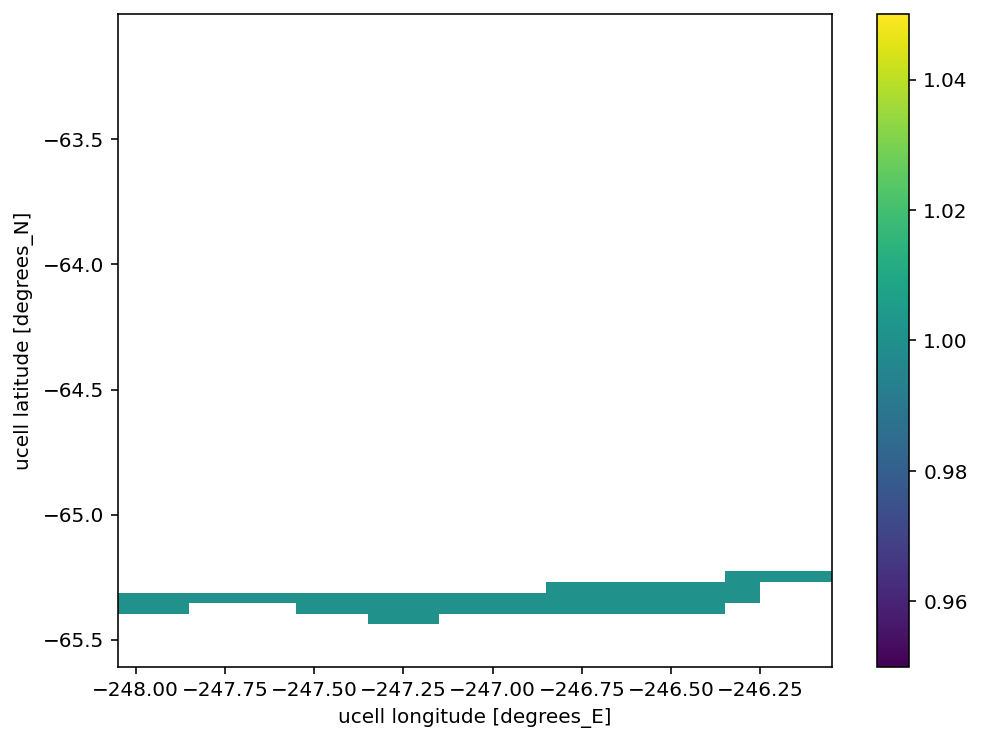

In [51]:
# Mask 

# set to 1 everywhere:
region_mask = hu*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_U5001000m.npz')
shelf_mask = contour_file['temp_maskU']
yu_ocean = contour_file['yu_ocean']
xu_ocean = contour_file['xu_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yu_ocean', yu_ocean), ('xu_ocean', xu_ocean)])

region_mask = region_mask * shelf_mask.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)

plt.figure(figsize=(8,6))
region_mask.plot()
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[700,1000,2000,3000],colors='k')
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_maskU,colors='grey')

In [52]:
#apply the mask
EKE_int_slope = EKE_int_slope*region_mask
EKE_int_slope = EKE_int_slope.where(EKE_int_slope!=0)

In [53]:
#u_slope

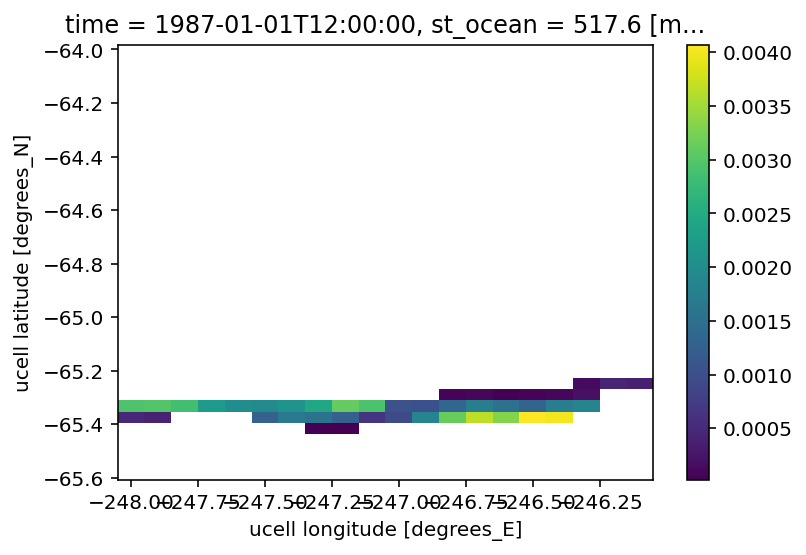

In [54]:
# first time step only:
EKE_int_slope[0,...].plot()

In [55]:
#AREA WEIGHTING #area t cant be found at iaf_cycle3
# area weighting:
area_u = cc.querying.getvar('01deg_jra55v13_ryf9091','area_u',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_u = area_u.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)


#add mask to area_t
#NRS added it here because it looks like area weighting also adds zero to masked area instead of nans 
area_u = area_u*region_mask

# sum area:
area_u_sum = area_u.sum('xu_ocean').sum('yu_ocean')

# Apply area weight:
EKE1 = (EKE_int_slope*area_u).sum('xu_ocean').sum('yu_ocean')/area_u_sum

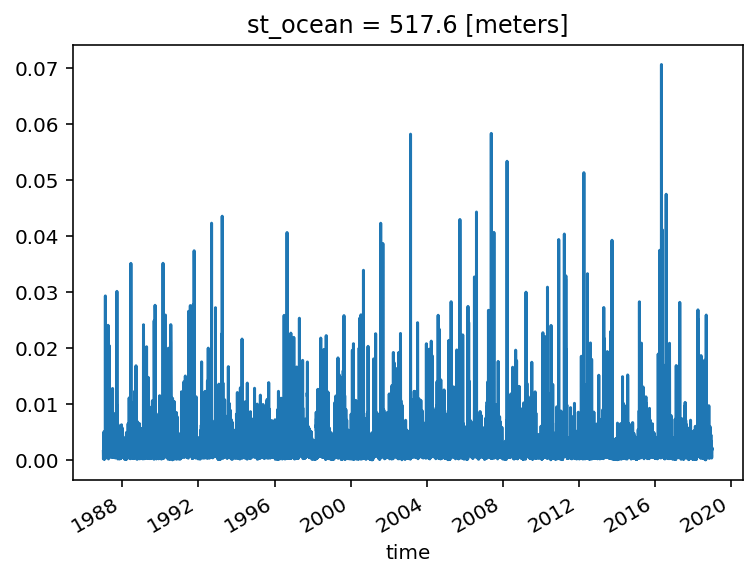

In [56]:
EKE1.plot();


In [57]:
EKE1=EKE1.load()

## Load EKE just at where we think the water comes in from 

In [58]:
EKE_int_slope = EKE

In [59]:
## this was designed for the areas of the slope where the average EKE was high
#lat_slice  = slice(-65.5, -63)
#lon_slice  = slice(-251, -246)
lon_slice  = slice(-253.5, -251.5) # best -251
lat_slice  = slice(-65.25, -64.7)

# topography data:
hu = cc.querying.getvar(expt,'hu' , master_session,n=1)
hu = hu.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
land_maskU = np.squeeze(hu.values)*0
land_maskU[np.isnan(land_maskU)] = 1
land_maskU = np.where(land_maskU==1,land_maskU,np.nan)

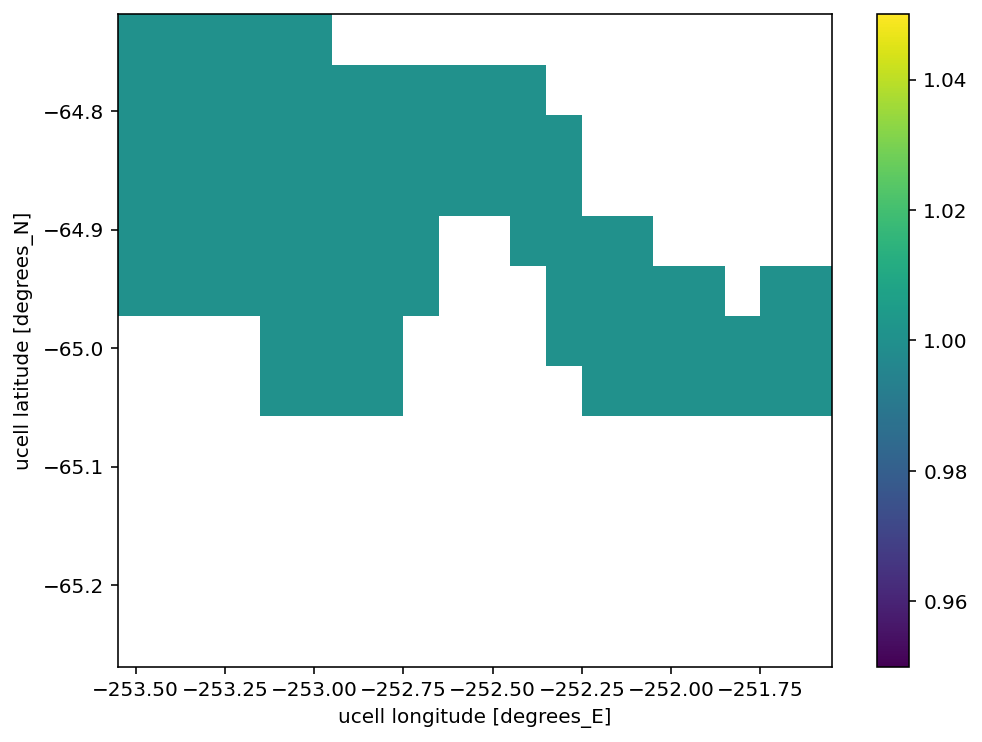

In [60]:
# Mask 

# set to 1 everywhere:
region_mask = hu*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_U7002500m.npz')
shelf_mask = contour_file['temp_maskU']
yu_ocean = contour_file['yu_ocean']
xu_ocean = contour_file['xu_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yu_ocean', yu_ocean), ('xu_ocean', xu_ocean)])

region_mask = region_mask * shelf_mask.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)

plt.figure(figsize=(8,6))
region_mask.plot()
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[700,1000,2000,3000],colors='k')
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_maskU,colors='grey')

In [61]:
#apply the mask
EKE_int_slope = EKE_int_slope*region_mask
EKE_int_slope = EKE_int_slope.where(EKE_int_slope!=0)

In [62]:
#u_slope

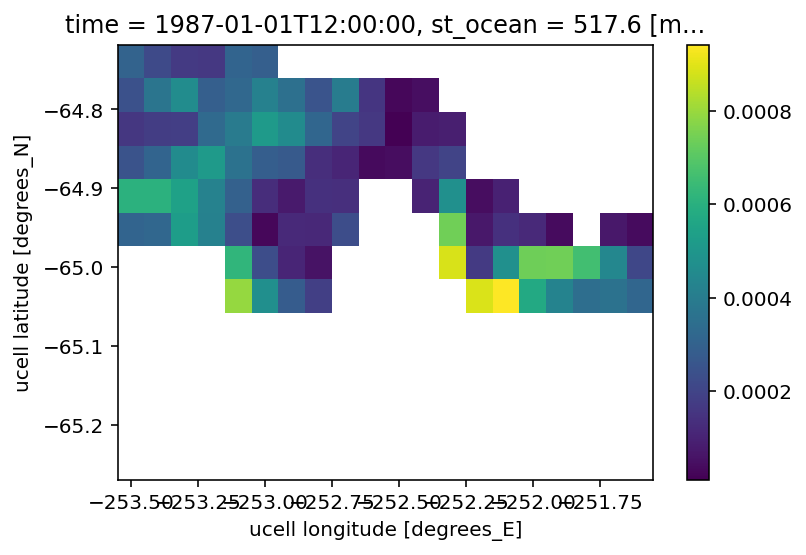

In [63]:
# first time step only:
EKE_int_slope[0,...].plot()

In [64]:
#AREA WEIGHTING #area t cant be found at iaf_cycle3
# area weighting:
area_u = cc.querying.getvar('01deg_jra55v13_ryf9091','area_u',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_u = area_u.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)


#add mask to area_t
#NRS added it here because it looks like area weighting also adds zero to masked area instead of nans 
area_u = area_u*region_mask

# sum area:
area_u_sum = area_u.sum('xu_ocean').sum('yu_ocean')

# Apply area weight:
EKE2 = (EKE_int_slope*area_u).sum('xu_ocean').sum('yu_ocean')/area_u_sum

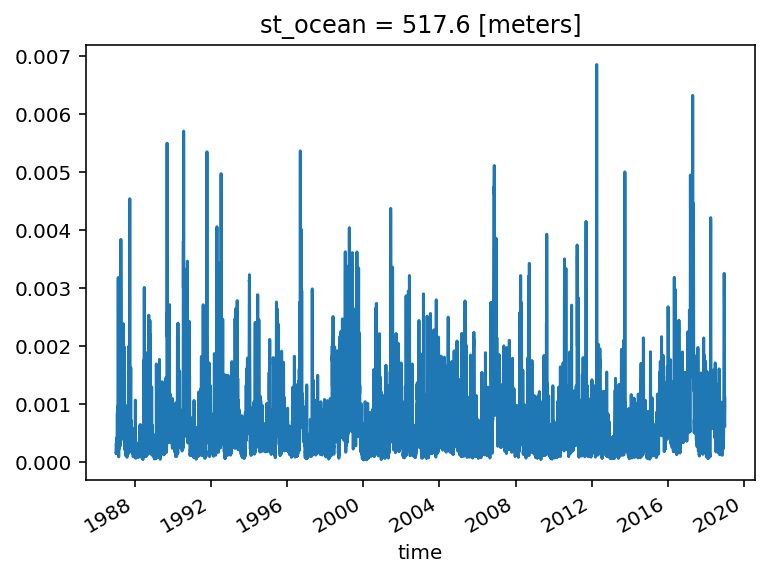

In [65]:
EKE2.plot();


In [66]:
EKE2=EKE2.load()

### Resample, detrend and apply rolling mean to them 

In [67]:
EKE_mth = EKE1.resample(time='1M').mean(dim='time')
EKE_mth2 = EKE2.resample(time='1M').mean(dim='time')

## Correlation Formula

In [69]:
def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or 
    for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    x = x.dropna(dim='time')
    y = y.dropna(dim='time')
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
     
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

# detrending function:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [70]:
## Note we need to first detrend the data:
EKE_d = detrend_dim(EKE_mth,'time')
EKE_dr = EKE_d.rolling(time=12, center=True).mean()
EKE_r = EKE_mth.rolling(time=12, center=True).mean()

## Note we need to first detrend the data:
EKE_d2 = detrend_dim(EKE_mth2,'time')
EKE_dr2 = EKE_d2.rolling(time=12, center=True).mean()
EKE_r2 = EKE_mth2.rolling(time=12, center=True).mean()

### PREPARE TEMPERATURE

In [71]:
# load temperature data at 400m:

depth_slice = slice(400, 6000)
# cut the data BOX 1
lon_slice  = slice(-252.7, -251.7)
lat_slice  = slice(-65.35, -65.1)

temp_400m = cc.querying.getvar(iaf_cycle3,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_400m = temp_400m.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice)


2023-05-20 11:31:59,595 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-05-20 11:32:00,071 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-05-20 11:32:00,662 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-05-20 11:32:01,128 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-05-20 11:32:01,181 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-05-20 11:32:01,437 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-05-20 11:32:02,350 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


In [72]:
# depth average:
# there is no dzu saved
# calculate grid thickness, adjusted for partial cells:
zlevel1 = 400
zlevel2 = 6000

# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(iaf_cycle3,'st_edges_ocean',master_session,
                 start_time=start_time, end_time=end_time,n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean':temp_400m.yt_ocean,'xt_ocean':temp_400m.xt_ocean},axis=[1,2])
# import bathymetry:
ht = cc.querying.getvar(iaf_cycle3,'ht',master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht,other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(iaf_cycle3,'st_ocean',master_session,n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

# select correct depths:
thickness = thickness.sel(st_ocean=slice(zlevel1,zlevel2))

# multiply by thickness to avg
temp_400m = (temp_400m*thickness).sum('st_ocean')/thickness.sum('st_ocean')

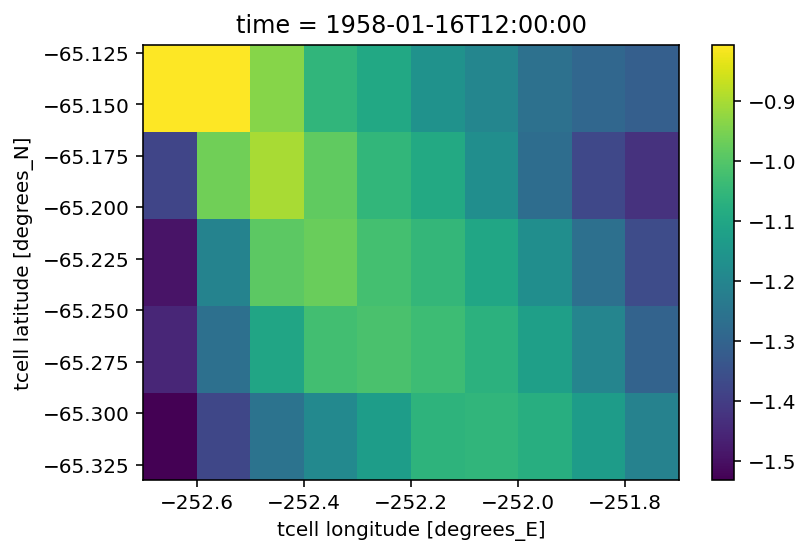

In [73]:
##test if temp is still working after the depth weighting
temp_400m[0,...].plot()

In [74]:
#AREA WEIGHTING #area t cant be found at iaf_cycle3
# area weighting:
area_t = cc.querying.getvar('01deg_jra55v13_ryf9091','area_t',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_t = area_t.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

# sum area:
area_t_sum = area_t.sum('xt_ocean').sum('yt_ocean')

# Apply area weight:
temp_400m = (temp_400m*area_t).sum('xt_ocean').sum('yt_ocean')/area_t_sum


In [75]:
temp_400m = temp_400m.load()

In [76]:
temp_teste = temp_400m.resample(time='1M').mean(dim='time')

#### Detrend time series and apply rolling mean 

In [77]:
# Note we need to first detrend the data:
temp_400m_zad = detrend_dim(temp_teste,'time')
temp_400m_zadr = temp_400m_zad.rolling(time=12, center=True).mean()
temp_400m_r = temp_teste.rolling(time=12, center=True).mean()



### CORRELATIONS WITH EKE vs TEMP

### EKE on the upstream slope where anomalies are higher

In [79]:
cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(EKE_dr,temp_400m_zadr)
print(cor)

<xarray.DataArray ()>
array(0.26867188)
Coordinates:
    st_ocean  float64 517.6


In [92]:
# AA
s=14;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(EKE_dr,temp_400m_r,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -13 :  <xarray.DataArray ()>
array(0.35130159)
Coordinates:
    st_ocean  float64 517.6
lag -12 :  <xarray.DataArray ()>
array(0.38221164)
Coordinates:
    st_ocean  float64 517.6
lag -11 :  <xarray.DataArray ()>
array(0.4095447)
Coordinates:
    st_ocean  float64 517.6
lag -10 :  <xarray.DataArray ()>
array(0.43266188)
Coordinates:
    st_ocean  float64 517.6
lag -9 :  <xarray.DataArray ()>
array(0.45135691)
Coordinates:
    st_ocean  float64 517.6
lag -8 :  <xarray.DataArray ()>
array(0.46276009)
Coordinates:
    st_ocean  float64 517.6
lag -7 :  <xarray.DataArray ()>
array(0.46532481)
Coordinates:
    st_ocean  float64 517.6
lag -6 :  <xarray.DataArray ()>
array(0.45674695)
Coordinates:
    st_ocean  float64 517.6
lag -5 :  <xarray.DataArray ()>
array(0.44126087)
Coordinates:
    st_ocean  float64 517.6
lag -4 :  <xarray.DataArray ()>
array(0.42312344)
Coordinates:
    st_ocean  float64 517.6
lag -3 :  <xarray.DataArray ()>
array(0.40024662)
Coordinates:
    st_ocean  float64 51

### EKE on the slope area where we think intrusions come in from 

In [86]:
cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(EKE_dr2,temp_400m_zadr)
print(cor)

<xarray.DataArray ()>
array(-0.19376543)
Coordinates:
    st_ocean  float64 517.6


In [87]:
# AA
s=14;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(EKE_dr2,temp_400m_r,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -13 :  <xarray.DataArray ()>
array(-0.20990251)
Coordinates:
    st_ocean  float64 517.6
lag -12 :  <xarray.DataArray ()>
array(-0.22654281)
Coordinates:
    st_ocean  float64 517.6
lag -11 :  <xarray.DataArray ()>
array(-0.23917358)
Coordinates:
    st_ocean  float64 517.6
lag -10 :  <xarray.DataArray ()>
array(-0.24828926)
Coordinates:
    st_ocean  float64 517.6
lag -9 :  <xarray.DataArray ()>
array(-0.25306041)
Coordinates:
    st_ocean  float64 517.6
lag -8 :  <xarray.DataArray ()>
array(-0.25180164)
Coordinates:
    st_ocean  float64 517.6
lag -7 :  <xarray.DataArray ()>
array(-0.24695485)
Coordinates:
    st_ocean  float64 517.6
lag -6 :  <xarray.DataArray ()>
array(-0.24077277)
Coordinates:
    st_ocean  float64 517.6
lag -5 :  <xarray.DataArray ()>
array(-0.2349729)
Coordinates:
    st_ocean  float64 517.6
lag -4 :  <xarray.DataArray ()>
array(-0.22981917)
Coordinates:
    st_ocean  float64 517.6
lag -3 :  <xarray.DataArray ()>
array(-0.22519282)
Coordinates:
    st_ocean 

### SUMMARY OF CORRELATION RESULTS
#### So there only is any correlations with the upper slope region. Even then very low. 0.3, best 0.5 in 6 months time (lag on EKE, as we are looking for a response). 
#### after the intrusions have happened.
#### If I invert the lags correlations decrease with time anyway. 

### Make the separate plot for temp and EKE upstream on the slope correlation

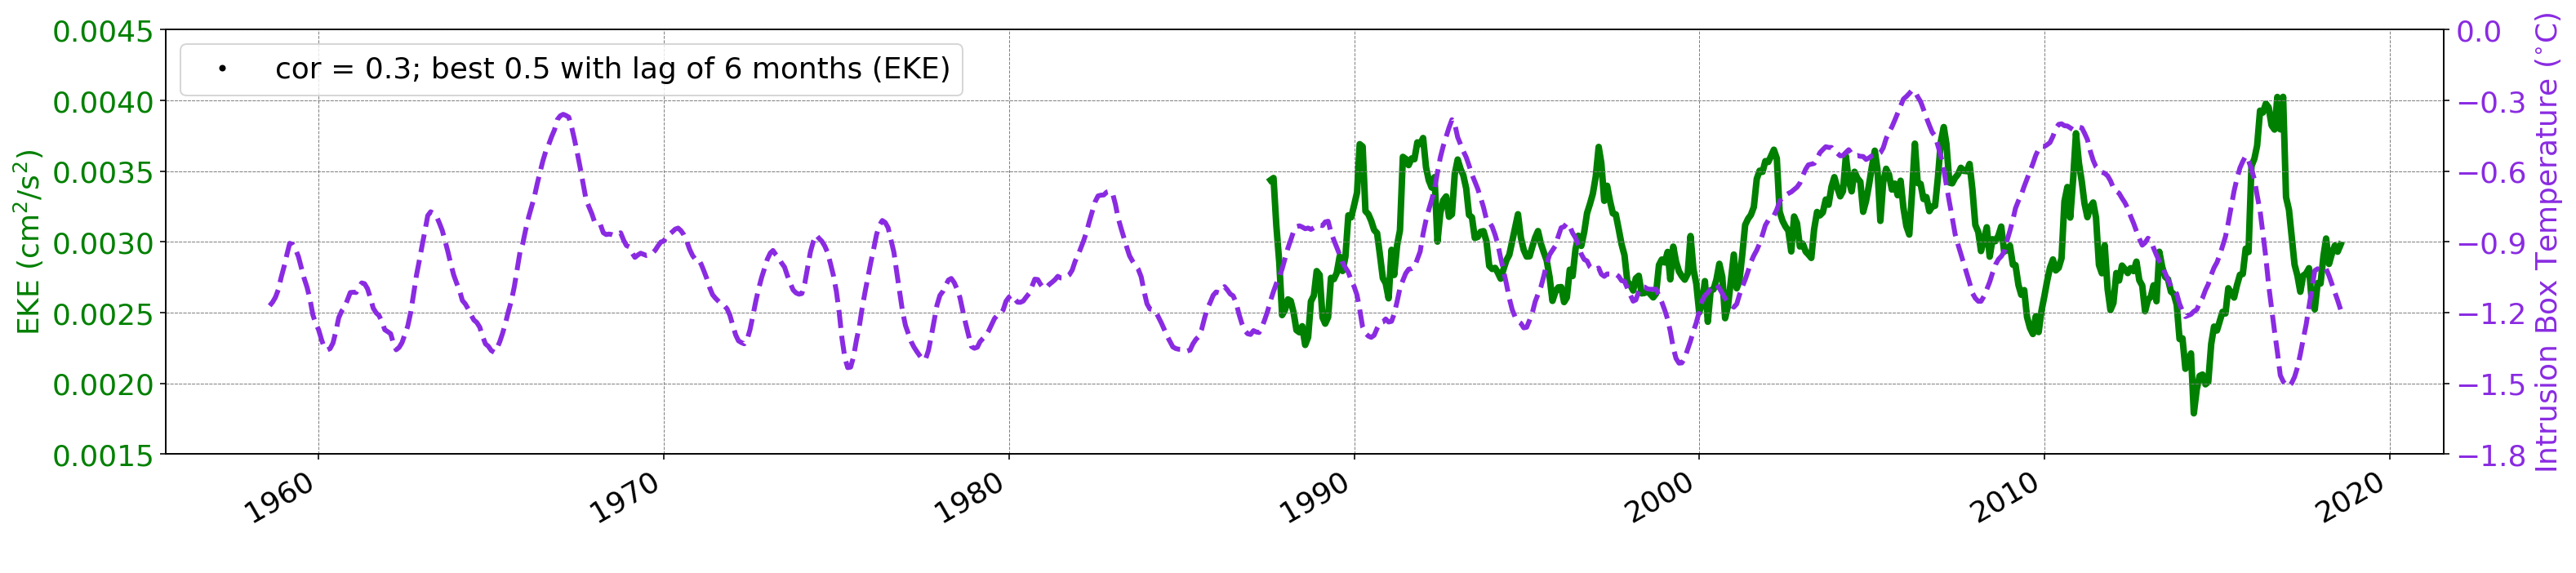

In [101]:
fontsize=18
fig=plt.figure(figsize=(25, 22))
fig.subplots_adjust(top=0.88)


ax1 = plt.subplot(4, 1, 1)
EKE_r.plot(color='green',linewidth=4)
ax1.set_ylabel('EKE (cm$^{2}$/s$^{2}$)', fontsize=fontsize,color='green')
ax1.tick_params(axis='y', labelcolor='green',labelsize=fontsize)

#sets the number of ticks in each side
ax1.yaxis.set_major_locator(plt.MaxNLocator(7))
ax1.set_xlabel(' ', fontsize = fontsize)
ax1.tick_params(axis='x',labelsize=fontsize)
plt.title('')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.ylim([0.0015,0.0045])
# set y-tick values and labels for first axis
ax1.set_yticks(np.linspace(0.0015,0.0045, 7))


ax2 = ax1.twinx()
#isocon_off_dr.plot(color='C0')
temp_400m_r.plot(color='blueviolet',linestyle='--',linewidth=3)
#isocon_off3_dr.plot(color='C0',linestyle=':')
ax2.set_ylabel('Intrusion Box Temperature ($^{\circ}$C)', fontsize=fontsize, color='blueviolet')
ax2.tick_params(axis='x',labelsize=fontsize)
#sets the number of ticks in each side
ax2.yaxis.set_major_locator(plt.MaxNLocator(7))
ax2.tick_params(axis='y', labelcolor='blueviolet',labelsize=fontsize)
#ax2.invert_yaxis()
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
#plt.text(700, -0.4, 'cor=0.016', fontsize = 12)
#building legend
#plt.plot(np.nan,np.nan,color='C0',linestyle=':',label='27.80')
plt.plot(np.nan,np.nan,color='k',marker=".",linestyle='none',label='cor = 0.3; best 0.5 with lag of 6 months (EKE)')
#plt.plot(np.nan,np.nan,color='C0',label='27.83')
plt.legend(loc="upper left",fontsize=fontsize)
plt.ylim([-1.6,-0.2])
# set y-tick values and labels for first axis
ax2.set_yticks(np.linspace(-1.8, 0, 7))

figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
filestr = figdir+'/fig_EKE_temp_time_series.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')